# t-SNE Exploration

In [205]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv('../data/processed/NY_SLI_ATTOM_NEW.csv')
df_numeric_data = df.drop(columns=[
    'Lead Gooseneck, Pigtail or Connector Currently Present',
    'Current Public Side SL Material',
    'Was Public SL Material Ever Previously Lead',
    'Public SL Material Verification Method',
    'Customer SL Material',
    'Lead Solder Present',
    'Customer SL Size',
    'SL Category', 
    'Note', 
    'Location', 
    'Current SL Material Category', 'Lead Connector Present Category',
    'Current Public Side SL Material Category',
    'Was Public SL Material Ever Previously Lead Category',
    'Public SL Size Numeric', 'SL Category Cleaned',
    'attomID',
    'Service Line Locality',
    'Street Address',
    'State',
    'Public SL Size',
    'Customer SL Material Verification Method',
    'POU or POE Treatment Present',
    'Building Type',
    'prop_class',
    'size_ind',
    'Public SL Installation Year',
    'Public SL Material Verification Method Category',
    'Customer SL Installation or Replacement Date',
    'Public SL Size Category',
    'Zip Code'
])
print(df_numeric_data.columns)
def safe_float(x):
    try:
        return float(x)
    except (ValueError, TypeError):
        return False

def condition_numeric(x):
    if x == 'NaN' or type(x) == float: # only if nan
        return 0
    if x == 'FAIR':
        return 1
    if x == 'AVERAGE':
        return 2
    if x == 'GOOD':
        return 3
    if x == 'EXCELLENT':
        return 4
    
df_numeric_data = df_numeric_data[df_numeric_data['Public SL Installation or Replacement Date'].apply(lambda x: safe_float(x) > 1500 and safe_float(x) < 2025)]
df_numeric_data['construction_condition'] = df_numeric_data['construction_condition'].apply(condition_numeric)
df_numeric_data['Public SL Installation or Replacement Date'] = df_numeric_data['Public SL Installation or Replacement Date'].apply(float)
for col in df_numeric_data:
    if col != 'Customer SL Material Category':
        df_numeric_data[col] = df_numeric_data[col].apply(float)
df_numeric_data

Index(['Public SL Installation or Replacement Date',
       'Customer SL Material Category', 'lot_size2', 'year_built',
       'living_size', 'beds', 'baths_total', 'levels', 'market_total_value',
       'construction_condition'],
      dtype='object')


,Public SL Installation or Replacement Date,Customer SL Material Category,lot_size2,year_built,living_size,beds,baths_total,levels,market_total_value,construction_condition
0,1976.0,Copper,7020.0,1900.0,2890.0,4.0,3.0,2.0,100000.0,2.0
1,1958.0,Copper,6250.0,1925.0,1336.0,3.0,1.0,2.0,83600.0,2.0
2,1965.0,Copper,23680.0,1987.0,900.0,0.0,0.0,1.0,296700.0,0.0
3,1968.0,Copper,14768.0,1920.0,1457.0,3.0,2.0,2.0,94300.0,2.0
4,1962.0,Copper,4200.0,1900.0,1600.0,4.0,2.0,2.0,32800.0,1.0
...,...,...,...,...,...,...,...,...,...,...
691,1940.0,Copper,10538.0,1900.0,1821.0,6.0,2.0,2.0,182333.0,1.0
693,1955.0,Copper,3339.0,1920.0,2155.0,4.0,2.0,2.0,232595.0,2.0
694,1977.0,Copper,34034.0,1978.0,1842.0,4.0,3.0,2.0,321356.0,2.0
697,1950.0,Copper,7830.0,1920.0,1056.0,2.0,1.0,1.0,177521.0,2.0


In [206]:
y = df_numeric_data['Customer SL Material Category']
df_numeric_data = df_numeric_data.drop(columns='Customer SL Material Category')
X = df_numeric_data.to_numpy()
X = np.hstack([X[:, 0:2], X[:, 3:]])
y = y[~np.isnan(X).any(axis=1)]
X = X[~np.isnan(X).any(axis=1)]
X

array([[1.97600e+03, 7.02000e+03, 2.89000e+03, ..., 2.00000e+00,
        1.00000e+05, 2.00000e+00],
       [1.95800e+03, 6.25000e+03, 1.33600e+03, ..., 2.00000e+00,
        8.36000e+04, 2.00000e+00],
       [1.96500e+03, 2.36800e+04, 9.00000e+02, ..., 1.00000e+00,
        2.96700e+05, 0.00000e+00],
       ...,
       [1.97700e+03, 3.40340e+04, 1.84200e+03, ..., 2.00000e+00,
        3.21356e+05, 2.00000e+00],
       [1.95000e+03, 7.83000e+03, 1.05600e+03, ..., 1.00000e+00,
        1.77521e+05, 2.00000e+00],
       [1.95000e+03, 8.31500e+03, 2.20200e+03, ..., 2.00000e+00,
        2.63715e+05, 2.00000e+00]])

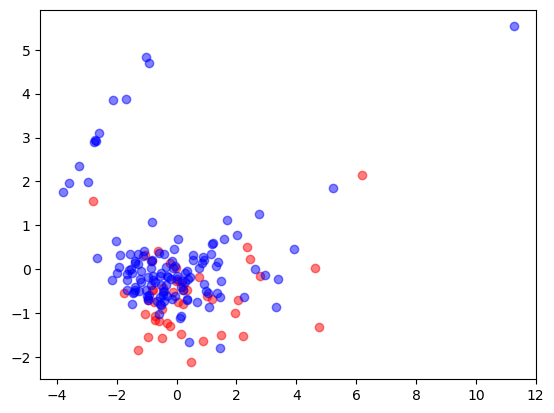

In [ ]:
scaler = StandardScaler()
tsne = TSNE(n_components=2)

X_scaled = scaler.fit_transform(X)
X_reduced = tsne.fit_transform(X_scaled)

colors = {'Lead': 'red', 'Copper': 'blue'}
for material, color in colors.items():
    idx = y == material
    plt.scatter(X_reduced[idx, 0], X_reduced[idx, 1], c=color, alpha=0.5)